```
FEB551 Quantitative Investing
Team: FatFinger

```

# 1.0 Mean-reverting strategy 

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
start = dt.datetime.now()

## with a hedge ratio of 1:1

In [2]:
def mean_reversion(df1, MA_length, exit_signal):
    '''
    Get the sharpe ratio on a mean reversion strategy over the whole period on the spread of two futures contracts. 
    The strategy involves using the bollinger band as an entry/exit signal. The entry point will be when the 
    price level hits 2 standard deviations above the moving average (whose period length is user-specificed) 
    and the exit signal is user-specified. For this variation, we use a simple 1-1 ratio of the specified contracts 
    (no hedge ratio). For return calculation, we take the average price level of the two contracts as 
    "committed capital." Finally, since contracts are rolled over on the first of each month, anytime we are in 
    the market during this time, the change in price levels is not calculated into our returns.
    '''
    
    df=df1.copy()

    # df is a dataframe with a date column, and two futures price data columns
    # MA_length is the length of the moving average we will use
    # exit_signal is the z score at which we will exit our position (+/- 2 stdevs is the entry)
    
    #read in daily risk-free rates data (obatined from WRDS)
    Rf = pd.read_csv("Rf.csv",header=0,names=['Date','Rf'])
    Rf.Date = pd.to_datetime(Rf.Date)
    
    #get relevant dates for risk free rate
    Rf = Rf[(Rf.Date >= df.Date[0]) & (Rf.Date <= df.Date[len(df.Date)-1])]
    Rf = Rf.reset_index(drop=True)
    
    #create the column for the spread
    df['Spread'] = df.iloc[:,1] - df.iloc[:,2]
    
    #create columns for moving average, rolling standard deviation, and z-score for the current price level of the spread
    df['MA'+str(MA_length)] = df.Spread.rolling(MA_length).mean()
    df['SD'+str(MA_length)] = df.Spread.rolling(MA_length).std()
    df['Z'+str(MA_length)] = (df.Spread-df['MA'+str(MA_length)])/df['SD'+str(MA_length)]
    
    
    ## creating signal column which determines when we are long/short the spread
    # determine initial entry points, which is when z-score is above 2 or below -2
    df["Signal"] = [1 if x < -2 else (-1 if x > 2 else 0) for x in df['Z'+str(MA_length)]]
    
    # fill in signal columns until the point where we receive an exit signal (determined by "exit_signal" variable)
    for i in range(1,len(df.index)):
        if df.iloc[i-1,7] == -1:
            if df.iloc[i,6] > -1*exit_signal:
                df.iloc[i,7] = -1
        elif df.iloc[i-1,7] == 1:
            if df.iloc[i,6] < exit_signal:
                df.iloc[i,7] = 1
            
    #lag signal column by 1 day (conservative approach)
    df.Signal = df.Signal.shift(1)
    
    #calculate returns; we will use the average price level of the two contracts as our investment/"employed capital"
    df['Ret'] = df.Spread.diff().shift(-1)/(df.iloc[:,1]+df.iloc[:,2])/2
    df.Ret = df.Ret*df.Signal

    
    #create indicator for contract roll-over days
    df['EOM'] = df.Date.shift(-1).dt.month != df.Date.dt.month
    
    #get summary statistics for returns
    returns = df.Ret[(df.Signal !=0) & (df.EOM == False)]
    returns = returns.dropna()
    stats = returns.describe()
    
    #get average daily risk free rate over the period
    stats2 = Rf.Rf.describe()

    sharpe = (stats[1]-stats2[1])/stats[2]*np.sqrt(252)
    
    return sharpe


### Part 1: WTI/Brent

In [3]:
#variables to try
MA_length = [10,15,20,50,100]
exit_signal = [-0.5,-0.2,0,0.2,0.5]

#read in crude oil futures data and daily risk-free rates data (obtained from WRDS)
crude = pd.read_csv("Crude_Oil.txt",sep="\t")
crude.Date = pd.to_datetime(crude.Date,dayfirst=True)
crude.columns = crude.columns.str.strip()


In [4]:
# WTI Front - Brent Front Spread
df1=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion(crude[["Date","RCLC1","LLCC1"]],i,j))
    df1[str(i)] = l

df1.index = exit_signal


In [5]:
# WTI 2nd month - Brent 2nd month
df2=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion(crude[["Date","RCLC2","LLCC2"]],i,j))
    df2[str(i)] = l

df2.index = exit_signal


In [6]:
# WTI 3rd month - Brent 3rd month
df3=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion(crude[["Date","RCLC3","LLCC3"]],i,j))
    df3[str(i)] = l

df3.index = exit_signal


In [7]:
# WTI 4th month - Brent 4th month
df4=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion(crude[["Date","RCLC4","LLCC4"]],i,j))
    df4[str(i)] = l

df4.index = exit_signal



In [8]:
# WTI 5th month - Brent 5th month
df5=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion(crude[["Date","RCLC5","LLCC5"]],i,j))
    df5[str(i)] = l

df5.index = exit_signal


In [9]:
# WTI 6th month - Brent 6th month
df6=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion(crude[["Date","RCLC6","LLCC6"]],i,j))
    df6[str(i)] = l

df6.index = exit_signal


In [10]:
# WTI 1 year - Brent 1 year
df12=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion(crude[["Date","RCLC12","LLCC12"]],i,j))
    df12[str(i)] = l

df12.index = exit_signal


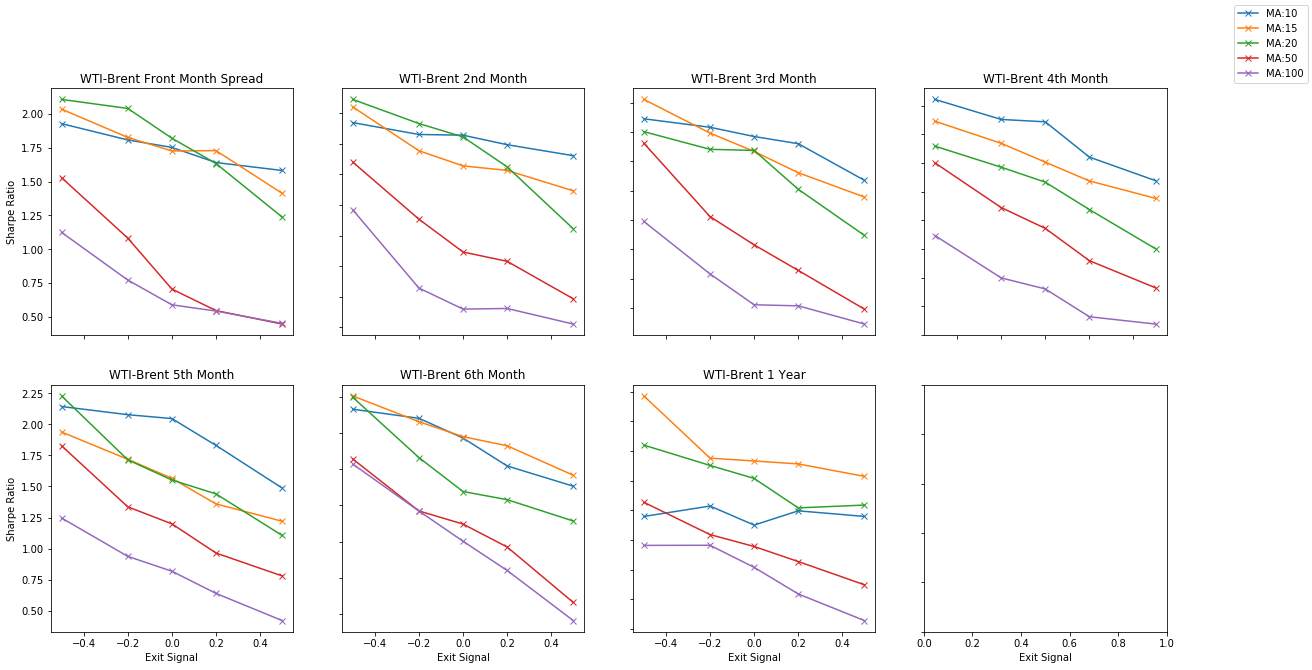

In [11]:
dfs = [df1,df2,df3,df4,df5,df6,df12]
titles = ["WTI-Brent Front Month Spread",
         "WTI-Brent 2nd Month",
         "WTI-Brent 3rd Month",
         "WTI-Brent 4th Month",
         "WTI-Brent 5th Month",
         "WTI-Brent 6th Month",
         "WTI-Brent 1 Year"]

fig, axs = plt.subplots(2, 4,figsize=(20,10))

c=0
for i in [0,1]:
    for j in [0,1,2,3]:
        if c==0:
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,0], 'x-', label="MA:10")
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,1], 'x-', label="MA:15")
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,2], 'x-', label="MA:20")
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,3], 'x-', label="MA:50")
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,4], 'x-', label="MA:100")
            axs[i, j].set_title(titles[c])
        elif c<7:
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,0], 'x-')
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,1], 'x-')
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,2], 'x-')
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,3], 'x-')
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,4], 'x-')
            axs[i, j].set_title(titles[c])
            
        c+=1


fig.legend()

for ax in axs.flat:
    ax.set(xlabel='Exit Signal', ylabel='Sharpe Ratio')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# 1.2) Mean-reverting strategy with dynamic hedge ratio

## Mean-reverting strategy with a dynamic hedge ratio computed based on Kalman Filter

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import pandas_datareader as pdr
# might need to install KalmanFilter
# pip install pykalman 
from pykalman import KalmanFilter

/Users/kwlwman2/Anaconda3/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [13]:
def draw_date_coloured_scatterplot(futs, prices):
    """
    Create a scatterplot of the two futures prices, 
    which is coloured by the date of the price to indicate 
    the changing relationship between the sets of prices    
    """
    plt.figure(figsize=(20,10))
    
    # Create a yellow-to-red colourmap where yellow indicates
    # early dates and red indicates later dates
    plen = len(prices)
    colour_map = plt.cm.get_cmap('YlOrRd')    
    colours = np.linspace(0.1, 1, plen)
    
    # Create the scatterplot object
    scatterplot = plt.scatter(
        prices[futs[0]], prices[futs[1]], 
        s=30, c=colours, cmap=colour_map, 
        edgecolor='k', alpha=0.8
    )
    
    # Add a colour bar for the date colouring and set the 
    # corresponding axis tick labels to equal string-formatted dates
    colourbar = plt.colorbar(scatterplot)
    colourbar.ax.set_yticklabels(
        [str(p.date()) for p in prices[::plen//9].index]
    )
    plt.xlabel(prices.columns[0])
    plt.ylabel(prices.columns[1])
    plt.show()

In [14]:
crude = pd.read_csv("Crude_Oil.txt",sep="\t")
crude.Date = pd.to_datetime(crude.Date,dayfirst=True)
crude.columns = crude.columns.str.strip()

crude_intercommodity = crude[["Date","RCLC1","LLCC1"]]
crude_intercommodity = crude.set_index("Date",drop=True)

# RCLC refers to WTI futures traded on the NYMEX; LLCC refers to Brent Crude futures traded on the ICE
# The number represents the number of months to delivery i.e. 1 refers to the front month contract


### inter-commodity spread relationship

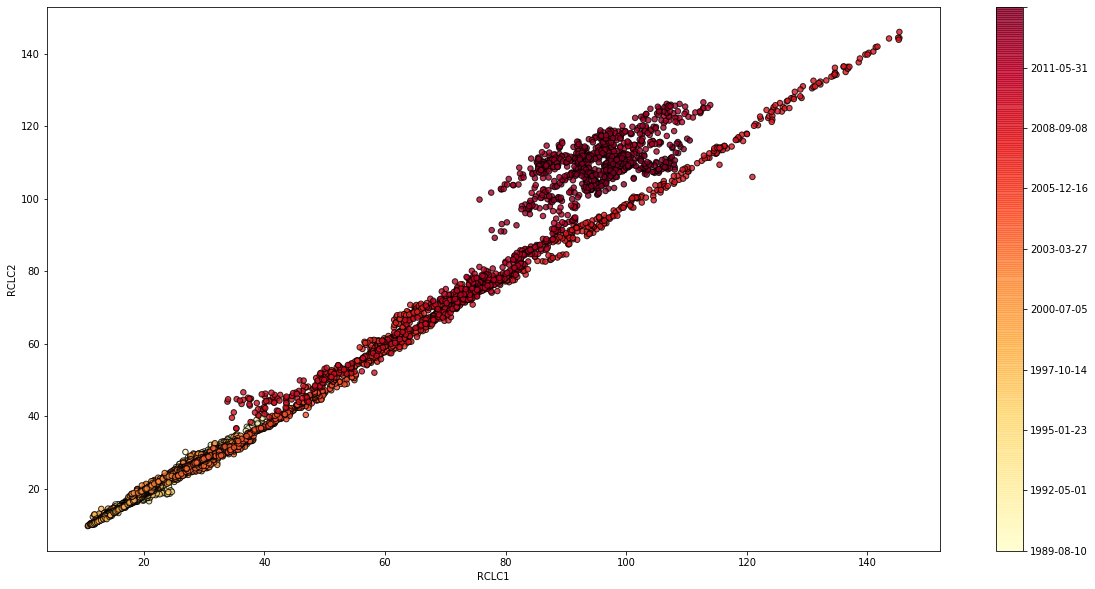

In [15]:
futs = ["RCLC1","LLCC1"]
draw_date_coloured_scatterplot(futs, crude_intercommodity)

### calendar spread Relationship

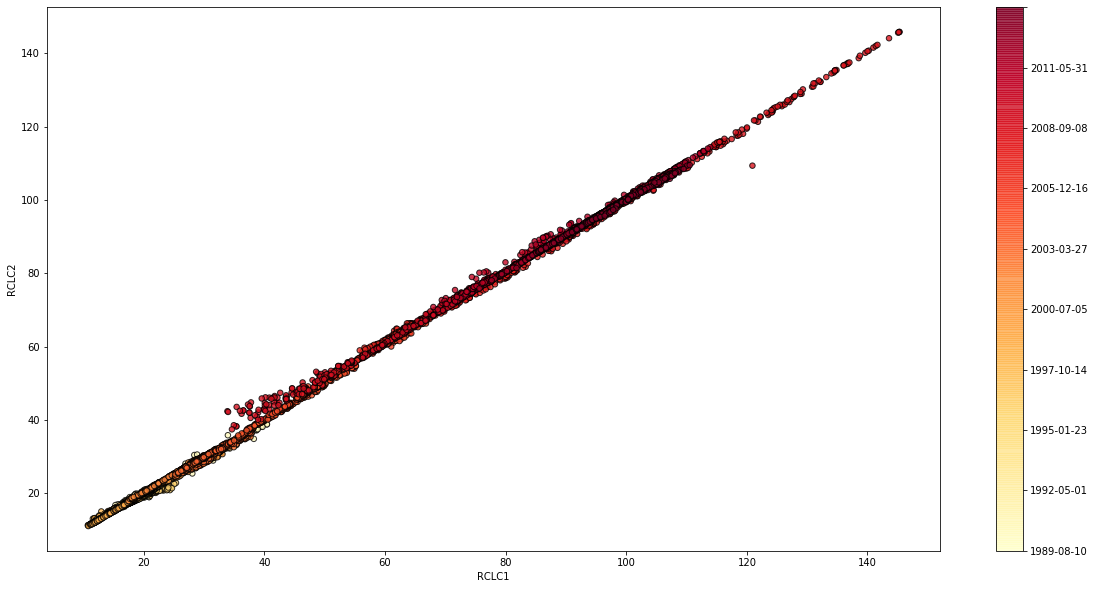

In [16]:
crude_calendar = crude[["Date","RCLC1","RCLC2"]]
crude_calendar = crude.set_index("Date",drop=True)

futs = ["RCLC1","RCLC2"]
draw_date_coloured_scatterplot(futs, crude_calendar)

In [17]:
def calc_slope_intercept_kalman(futs, prices, delta):
    """
    Utilise the Kalman Filter from the pyKalman package
    to calculate the slope and intercept of the regressed
    futures prices.
    """
    
    delta = delta
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack(
        [prices[futs[0]], np.ones(prices[futs[0]].shape)]
    ).T[:, np.newaxis]
    
    kf = KalmanFilter(
        n_dim_obs=1, 
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )
        
    state_means, state_covs = kf.filter(prices[futs[1]].values)
    return state_means, state_covs

### Inter-commodity spread intercept and hedge ratio

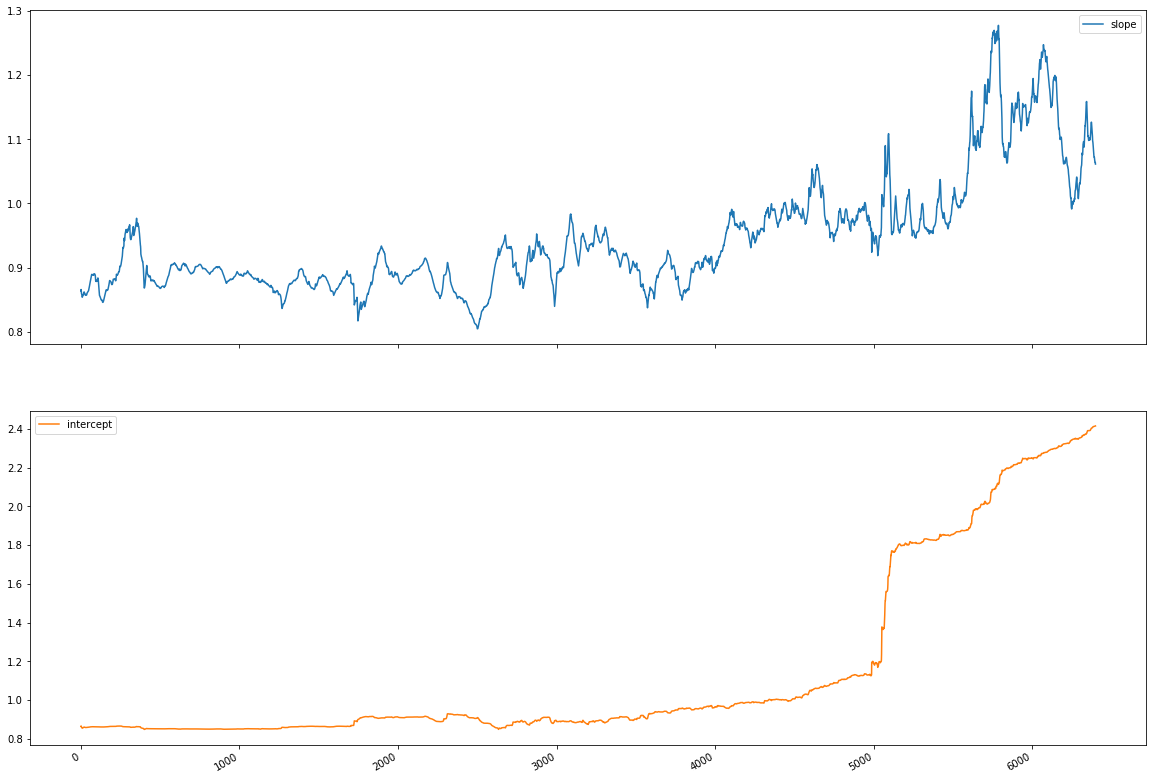

In [18]:
def draw_slope_intercept_changes(prices, state_means):
    """
    Plot the slope and intercept changes from the 
    Kalman Filter calculated values.
    """

    pd.DataFrame(
        dict(
            slope=state_means[:, 0], 
            intercept=state_means[:, 1]
        ), index=prices.index
    ).plot(subplots=True,figsize=(20,15))
    plt.show()
  
# inter-commodity spread intercept and hedge ratio
futs = ["RCLC1","LLCC1"]
draw_slope_intercept_changes(crude, calc_slope_intercept_kalman(futs, crude_intercommodity, 1e-5)[0])

### Calendar spread intercept and hedge ratio

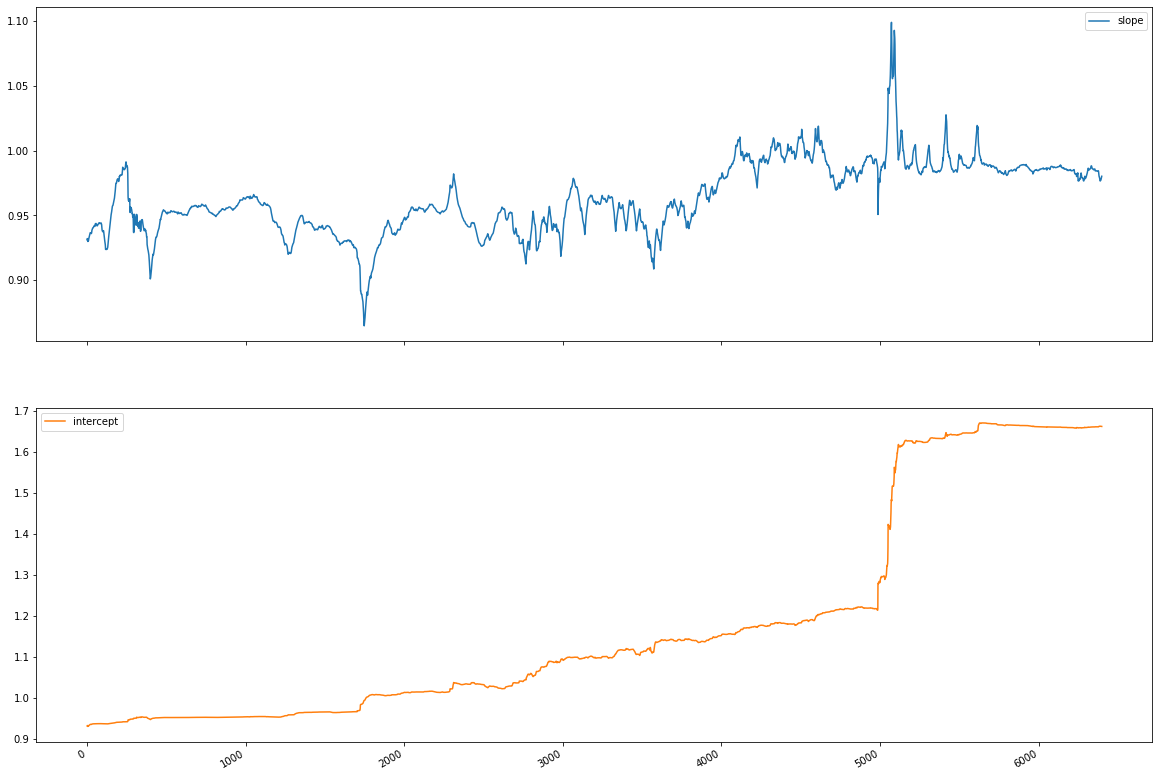

In [19]:
futs = ["RCLC1","RCLC2"]
draw_slope_intercept_changes(crude, calc_slope_intercept_kalman(futs, crude_calendar, 1e-5)[0])

In [20]:
def mean_reversion_dynamic(df1, MA_length, exit_signal):
    '''
    Get the sharpe ratio on a mean reversion strategy over the whole period on the spread of two futures contracts. 
    The strategy involves using the bollinger band as an entry/exit signal. The entry point will be when the 
    price level hits 2 standard deviations above the moving average (whose period length is user-specificed) 
    and the exit signal is user-specified. For this variation, we use a simple 1-1 ratio of the specified contracts 
    (no hedge ratio). For return calculation, we take the average price level of the two contracts as 
    "committed capital." Finally, since contracts are rolled over on the first of each month, anytime we are in 
    the market during this time, the change in price levels is not calculated into our returns.
    '''
    
    df=df1.copy()

    # df is a dataframe with a date column, and two futures price data columns
    # MA_length is the length of the moving average we will use
    # exit_signal is the z score at which we will exit our position (+/- 2 stdevs is the entry)
    
    #read in daily risk-free rates data (obatined from WRDS)
    Rf = pd.read_csv("Rf.csv",header=0,names=['Date','Rf'])
    Rf.Date = pd.to_datetime(Rf.Date)
    
    #get relevant dates for risk free rate
    Rf = Rf[(Rf.Date >= df.Date[0]) & (Rf.Date <= df.Date[len(df.Date)-1])]
    Rf = Rf.reset_index(drop=True)
    
    
    #create updating list of hedge ratios using KalmanFilter function
    
    #create inputs for the function
    prices = df1.copy()
    prices = prices.set_index("Date",drop=True)
    futs = list(prices.columns)
    
    #run function and extract slopes (hedge ratio)
    hedge_ratio = pd.DataFrame(calc_slope_intercept_kalman(futs, prices, 1e-5)[0])
    hedge_ratio = hedge_ratio.iloc[:,0]


    #create the column for the spread
    # a "hedged portfolio" is created by hedging the front leg of the spread using the previously obtained ratio
    df['Spread'] = df.iloc[:,1]*hedge_ratio - df.iloc[:,2]
    
    #create columns for moving average, rolling standard deviation, and z-score for the current price level of the spread
    df['MA'+str(MA_length)] = df.Spread.rolling(MA_length).mean()
    df['SD'+str(MA_length)] = df.Spread.rolling(MA_length).std()
    df['Z'+str(MA_length)] = (df.Spread-df['MA'+str(MA_length)])/df['SD'+str(MA_length)]
    
    
    ## creating signal column which determines when we are long/short the spread
    #determine initial entry points, which is when z-score is above 2 or below -2
    df["Signal"] = [1 if x < -2 else (-1 if x > 2 else 0) for x in df['Z'+str(MA_length)]]
    
    # fill in signal columns until the point where we receive an exit signal (determined by "exit_signal" variable)
    for i in range(1,len(df.index)):
        if df.iloc[i-1,7] == -1:
            if df.iloc[i,6] > -1*exit_signal:
                df.iloc[i,7] = -1
        elif df.iloc[i-1,7] == 1:
            if df.iloc[i,6] < exit_signal:
                df.iloc[i,7] = 1
    
    #lag signal column by 1 day (conservative approach)
    df.Signal = df.Signal.shift(1)
    
    #calculate returns; we will use the average price level of the two contracts as our investment/"employed capital"
    df['Ret'] = df.Spread.diff().shift(-1)/(df.iloc[:,1]+df.iloc[:,2])/2
    df.Ret = df.Ret*df.Signal
    
    
    #create indicator for contract roll-over days
    df['EOM'] = df.Date.shift(-1).dt.month != df.Date.dt.month
    
    #get summary statistics for returns
    returns = df.Ret[(df.Signal !=0) & (df.EOM == False)]
    returns = returns.dropna()
    stats = returns.describe()
    
    #get average daily risk free rate over the period
    stats2 = Rf.Rf.describe()

    sharpe = (stats[1]-stats2[1])/stats[2]*np.sqrt(252)
    
    return sharpe



## Sharpe Ratios for various Inter-commodity Spread pairs

In [21]:
crude = pd.read_csv("Crude_Oil.txt",sep="\t")
crude.Date = pd.to_datetime(crude.Date,dayfirst=True)
crude.columns = crude.columns.str.strip()

In [22]:
#variables to try
MA_length = [10,15,20,50,100]
exit_signal = [-0.5,-0.2,0,0.2,0.5]

#read in crude oil futures data and daily risk-free rates data (obtained from WRDS)
crude = pd.read_csv("Crude_Oil.txt",sep="\t")
crude.Date = pd.to_datetime(crude.Date,dayfirst=True)
crude.columns = crude.columns.str.strip()

In [23]:
# WTI Front - Brent Front Spread
df1=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC1","LLCC1"]],i,j))
    df1[str(i)] = l

df1.index = exit_signal


In [24]:
# WTI 2nd month - Brent 2nd month
df2=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC2","LLCC2"]],i,j))
    df2[str(i)] = l

df2.index = exit_signal


In [25]:
# WTI 3rd month - Brent 3rd month
df3=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC3","LLCC3"]],i,j))
    df3[str(i)] = l

df3.index = exit_signal


In [26]:
# WTI 4th month - Brent 4th month
df4=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC4","LLCC4"]],i,j))
    df4[str(i)] = l

df4.index = exit_signal

In [27]:
# WTI 5th month - Brent 5th month
df5=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC5","LLCC5"]],i,j))
    df5[str(i)] = l

df5.index = exit_signal


In [28]:
# WTI 6th month - Brent 6th month
df6=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC6","LLCC6"]],i,j))
    df6[str(i)] = l

df6.index = exit_signal


In [29]:
# WTI 1 year - Brent 1 year
df12=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC12","LLCC12"]].dropna().reset_index(drop=True),i,j))
    df12[str(i)] = l

df12.index = exit_signal


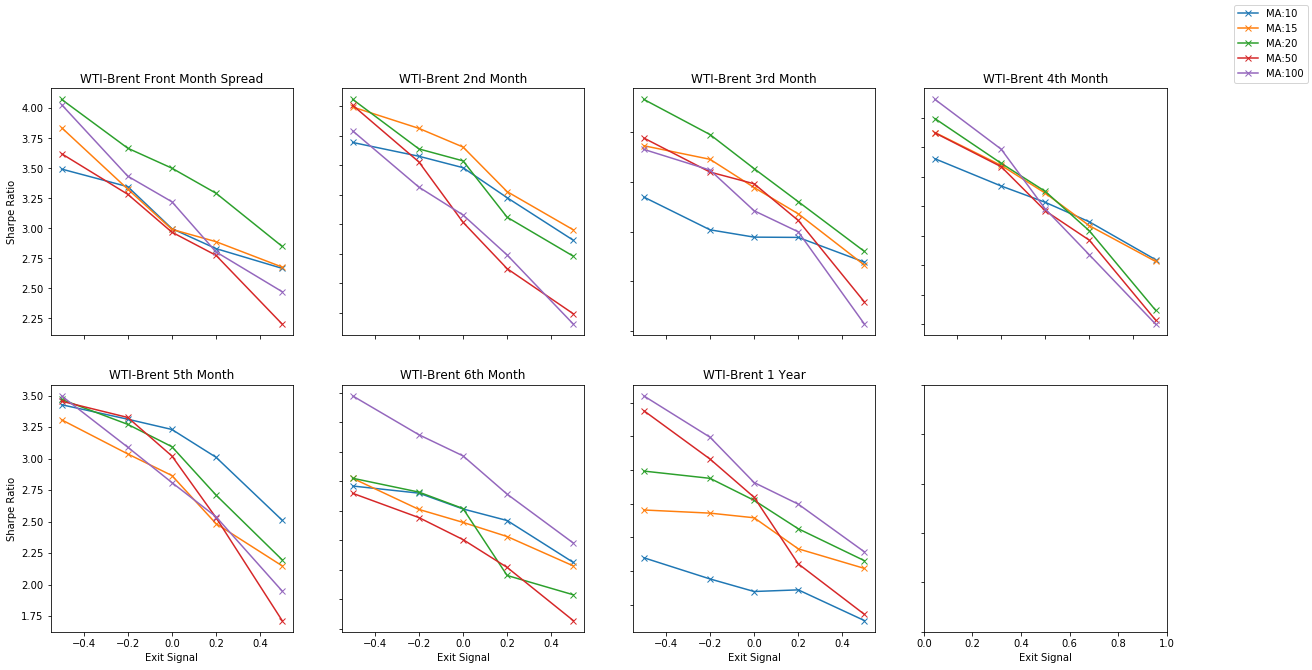

In [30]:
dfs = [df1,df2,df3,df4,df5,df6,df12]
titles = ["WTI-Brent Front Month Spread",
         "WTI-Brent 2nd Month",
         "WTI-Brent 3rd Month",
         "WTI-Brent 4th Month",
         "WTI-Brent 5th Month",
         "WTI-Brent 6th Month",
         "WTI-Brent 1 Year"]

fig, axs = plt.subplots(2, 4,figsize=(20,10))

c=0
for i in [0,1]:
    for j in [0,1,2,3]:
        if c==0:
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,0], 'x-', label="MA:10")
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,1], 'x-', label="MA:15")
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,2], 'x-', label="MA:20")
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,3], 'x-', label="MA:50")
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,4], 'x-', label="MA:100")
            axs[i, j].set_title(titles[c])
        elif c<7:
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,0], 'x-')
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,1], 'x-')
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,2], 'x-')
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,3], 'x-')
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,4], 'x-')
            axs[i, j].set_title(titles[c])
            
        c+=1


fig.legend()

for ax in axs.flat:
    ax.set(xlabel='Exit Signal', ylabel='Sharpe Ratio')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Sharpe ratios for various Calendar Spread pairs

In [31]:
#variables to try
MA_length = [10,15,20,50,100]
exit_signal = [-0.5,-0.2,0,0.2,0.5]

#read in crude oil futures data and daily risk-free rates data (obtained from WRDS)
crude = pd.read_csv("Crude_Oil.txt",sep="\t")
crude.Date = pd.to_datetime(crude.Date,dayfirst=True)
crude.columns = crude.columns.str.strip()

In [37]:
# WTI Front - WTI 2nd Spread
df1=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC1","RCLC2"]],i,j))
    df1[str(i)] = l

df1.index = exit_signal


In [38]:
# WTI Front - WTI 3rd Spread
df2=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC1","RCLC3"]],i,j))
    df2[str(i)] = l

df2.index = exit_signal


In [39]:
# WTI Front - WTI 6th Spread
df3=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC1","RCLC6"]],i,j))
    df3[str(i)] = l

df3.index = exit_signal


In [40]:
# WTI Front - WTI 1yr Spread
df4=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC1","RCLC12"]],i,j))
    df4[str(i)] = l

df4.index = exit_signal



In [41]:
# Brent Front - Brent 2nd Spread
df5=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","LLCC1","LLCC2"]],i,j))
    df5[str(i)] = l

df5.index = exit_signal


In [42]:
# Brent Front - Brent 6th month
df6=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","LLCC1","LLCC6"]],i,j))
    df6[str(i)] = l

df6.index = exit_signal


In [43]:
# Brent Front - Brent 1yr 
df7=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","LLCC1","LLCC12"]].dropna().reset_index(drop=True),i,j))
    df7[str(i)] = l

df7.index = exit_signal


In [44]:
# WTI 2nd - WTI 6th month
df8=pd.DataFrame()

for i in MA_length:
    l = []
    for j in exit_signal:
        l.append(mean_reversion_dynamic(crude[["Date","RCLC2","RCLC6"]].dropna().reset_index(drop=True),i,j))
    df8[str(i)] = l

df8.index = exit_signal

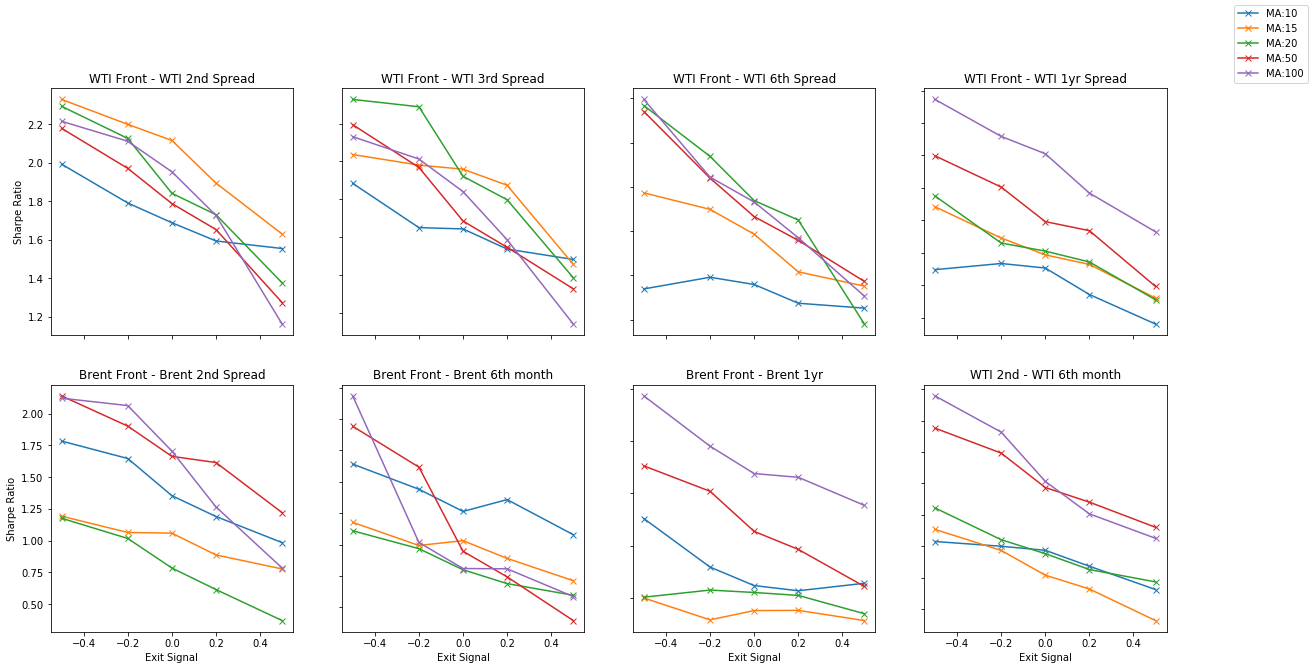

In [45]:
dfs = [df1,df2,df3,df4,df5,df6,df7,df8]
titles = ["WTI Front - WTI 2nd Spread",
         "WTI Front - WTI 3rd Spread",
         "WTI Front - WTI 6th Spread",
         "WTI Front - WTI 1yr Spread",
         "Brent Front - Brent 2nd Spread",
         "Brent Front - Brent 6th month",
         "Brent Front - Brent 1yr",
         "WTI 2nd - WTI 6th month"]

fig, axs = plt.subplots(2, 4,figsize=(20,10))

c=0
for i in [0,1]:
    for j in [0,1,2,3]:
        if c==0:
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,0], 'x-', label="MA:10")
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,1], 'x-', label="MA:15")
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,2], 'x-', label="MA:20")
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,3], 'x-', label="MA:50")
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,4], 'x-', label="MA:100")
            axs[i, j].set_title(titles[c])
        elif c<8:
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,0], 'x-')
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,1], 'x-')
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,2], 'x-')
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,3], 'x-')
            axs[i, j].plot(dfs[c].index, dfs[c].iloc[:,4], 'x-')
            axs[i, j].set_title(titles[c])
            
        c+=1


fig.legend()

for ax in axs.flat:
    ax.set(xlabel='Exit Signal', ylabel='Sharpe Ratio')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Portfolio Metrics

In [46]:
#have the function return the dataframe instead of the sharpe ratio

def mean_reversion_dynamic(df1, MA_length, exit_signal):
    '''
    Get the sharpe ratio on a mean reversion strategy over the whole period on the spread of two futures contracts. 
    The strategy involves using the bollinger band as an entry/exit signal. The entry point will be when the 
    price level hits 2 standard deviations above the moving average (whose period length is user-specificed) 
    and the exit signal is user-specified. For this variation, we use a simple 1-1 ratio of the specified contracts 
    (no hedge ratio). For return calculation, we take the average price level of the two contracts as 
    "committed capital." Finally, since contracts are rolled over on the first of each month, anytime we are in 
    the market during this time, the change in price levels is not calculated into our returns.
    '''
    
    df=df1.copy()

    # df is a dataframe with a date column, and two futures price data columns
    # MA_length is the length of the moving average we will use
    # exit_signal is the z score at which we will exit our position (+/- 2 stdevs is the entry)
    
    #read in daily risk-free rates data (obatined from WRDS)
    Rf = pd.read_csv("Rf.csv",header=0,names=['Date','Rf'])
    Rf.Date = pd.to_datetime(Rf.Date)
    
    #get relevant dates for risk free rate
    Rf = Rf[(Rf.Date >= df.Date[0]) & (Rf.Date <= df.Date[len(df.Date)-1])]
    Rf = Rf.reset_index(drop=True)
    
    
    #create updating list of hedge ratios using KalmanFilter function
    
    #create inputs for the function
    prices = df1.copy()
    prices = prices.set_index("Date",drop=True)
    futs = list(prices.columns)
    
    #run function and extract slopes (hedge ratio)
    hedge_ratio = pd.DataFrame(calc_slope_intercept_kalman(futs, prices, 1e-5)[0])
    hedge_ratio = hedge_ratio.iloc[:,0]


    #create the column for the spread
    # a "hedged portfolio" is created by hedging the front leg of the spread using the previously obtained ratio
    df['Spread'] = df.iloc[:,1]*hedge_ratio - df.iloc[:,2]
    
    #create columns for moving average, rolling standard deviation, and z-score for the current price level of the spread
    df['MA'+str(MA_length)] = df.Spread.rolling(MA_length).mean()
    df['SD'+str(MA_length)] = df.Spread.rolling(MA_length).std()
    df['Z'+str(MA_length)] = (df.Spread-df['MA'+str(MA_length)])/df['SD'+str(MA_length)]
    
    
    ## creating signal column which determines when we are long/short the spread
    #determine initial entry points, which is when z-score is above 2 or below -2
    df["Signal"] = [1 if x < -2 else (-1 if x > 2 else 0) for x in df['Z'+str(MA_length)]]
    
    # fill in signal columns until the point where we receive an exit signal (determined by "exit_signal" variable)
    for i in range(1,len(df.index)):
        if df.iloc[i-1,7] == -1:
            if df.iloc[i,6] > -1*exit_signal:
                df.iloc[i,7] = -1
        elif df.iloc[i-1,7] == 1:
            if df.iloc[i,6] < exit_signal:
                df.iloc[i,7] = 1
    
    #lag signal column by 1 day (conservative approach)
    df.Signal = df.Signal.shift(1)
    
    #calculate returns; we will use the average price level of the two contracts as our investment/"employed capital"
    df['Ret'] = df.Spread.diff().shift(-1)/(df.iloc[:,1]+df.iloc[:,2])/2
    df.Ret = df.Ret*df.Signal
    
    
    #create indicator for contract roll-over days
    df['EOM'] = df.Date.shift(-1).dt.month != df.Date.dt.month
    
    #get summary statistics for returns
    returns = df.Ret[(df.Signal !=0) & (df.EOM == False)]
    returns = returns.dropna()
    stats = returns.describe()
    
    #get average daily risk free rate over the period
    stats2 = Rf.Rf.describe()

    sharpe = (stats[1]-stats2[1])/stats[2]*np.sqrt(252)
    
    return df



In [47]:
#save returns dataframe
returns = mean_reversion_dynamic(crude[["Date","RCLC1","LLCC1"]],20,0)
returns.dropna(inplace=True)
returns

,Date,RCLC1,LLCC1,Spread,MA20,SD20,Z20,Signal,Ret,EOM
19,1989-09-06,19.28,17.74,-1.127695,-0.895614,0.167146,-1.388499,0.0,0.0,False
20,1989-09-07,19.41,17.76,-1.023328,-0.901374,0.169567,-0.719203,0.0,0.0,False
21,1989-09-08,19.75,17.72,-0.702250,-0.891197,0.175299,1.077855,0.0,-0.0,False
22,1989-09-11,19.76,17.72,-0.705227,-0.888838,0.177568,1.034032,0.0,-0.0,False
23,1989-09-12,19.70,17.66,-0.707970,-0.885511,0.180423,0.984024,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...
6393,2014-02-11,99.94,108.68,-1.977686,-1.628468,0.432462,-0.807511,0.0,0.0,False
6394,2014-02-12,100.37,108.79,-1.842864,-1.648071,0.432870,-0.450001,0.0,-0.0,False
6395,2014-02-13,100.35,108.73,-1.970131,-1.654485,0.436825,-0.722592,0.0,-0.0,False
6396,2014-02-14,100.30,109.08,-2.384503,-1.713945,0.451714,-1.484475,0.0,-0.0,False


In [48]:
#create cumulative product of returns for portfolio calculation
returns['PortRet'] = returns.Ret +1
returns.PortRet = returns.PortRet.cumprod()

In [49]:
#calculate number of "up days"
w = returns.Ret[(returns.Signal !=0) & (returns.EOM == False)]
winners = sum(w>0)/len(w)
winners

0.6122733612273361

In [50]:
#calculate time in market
in_market = len(w)/6397
in_market

0.22416757855244646

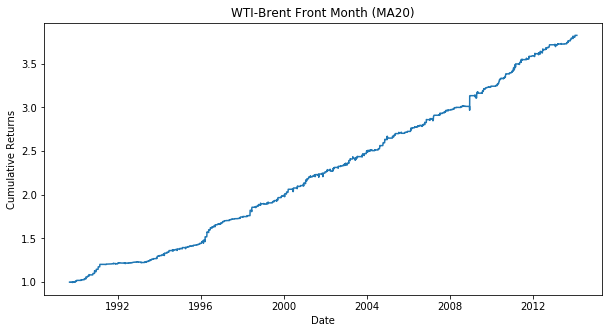

In [51]:
#create plot of portfolio
plt.figure(figsize=(10,5))
plt.plot(returns.Date,returns.PortRet)
plt.xlabel("Date")
plt.title("WTI-Brent Front Month (MA20)")
plt.ylabel("Cumulative Returns")
plt.show()

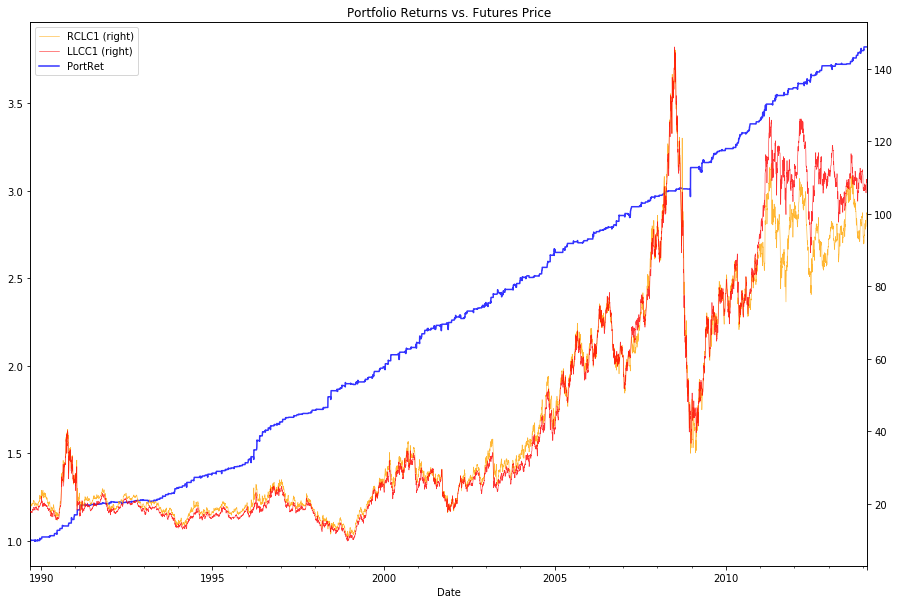

In [52]:
#create plot of portfolio vs. futures price over time
plt.figure(figsize=(15,10))
returns.plot('Date',['RCLC1'],ax=plt.gca(),secondary_y=True,lw='0.6',color='orange',zorder=0,alpha=0.8)
returns.plot('Date',['LLCC1'],ax=plt.gca(),secondary_y=True,color='r',lw='0.6',zorder=5,alpha=0.8)
returns.plot('Date',["PortRet"],ax=plt.gca(),lw='1.5',color='blue',zorder=10,alpha=0.8)
plt.title("Portfolio Returns vs. Futures Price")
plt.show()

In [53]:
#calculate max drawdown
mdd = returns.PortRet.cummax()
drawdowns = (mdd - returns.PortRet)/mdd
max_drawdown = max(drawdowns)
max_drawdown


0.0168534255978026

In [54]:
#calculate average holding period (time between entry and exit)
lst = list(returns.Signal)
l = []
from itertools import groupby
from operator import itemgetter

for k,v in groupby(enumerate(lst),key=itemgetter(1)):
    if k:
        v = list(v)
        l.append(v[-1][0]-v[0][0]+1)

num_trades = len(l)
print(num_trades)

avg_holding_period = sum(l)/len(l)
print(avg_holding_period)

284
5.264084507042254


# 2) Momentum - Energy Futures

### Momentum

- <u>__Objective__</u> <br>
The objective of this notebook is to test Momentum based trading strategies on a portfolio of futures contracts of 4 commodities: crude oil, natural gas, heating oil and gasoline. We test volatility for three time horizons: 15 day, 30 day and 40 day, and calculate the momentum based on the compounded returns over these time horizons.
<br>

- <u>__Method__</u> <br>
We create quintiles of the return momentum for the three time horizons

- <u>__Strategy__</u> <br> Buy when momentum is high, sell when momentum is high.<br>
We buy futures contracts which are in quintile 5 and and sell contracts which are in quintile 1.

- <u>__Results__</u> <br>
Our results show these momentum based strategies to be ineffective for the selected energy futures. The 30 day momentum horizon yields the best results, but still falls short in delivering a desirable sharpe ratio and significant returns.

In [55]:
# Importing Packages
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from functools import reduce
pd.set_option("display.max_columns", None)

In [56]:
# Read in energy futures data and daily risk-free rates data (obtained from WRDS)
# Defining Paths
crude_path = 'CrudeOil/'
gas_path = 'Gasoline/'
natgas_path = 'NatGas/'
heatoil_path = 'HeatOil/'

# Loading datasets
crude = pd.read_csv("Crude_Oil.txt",sep="\t")
crude.Date = pd.to_datetime(crude.Date,dayfirst=True)
crude.columns = crude.columns.str.strip()

gas = pd.read_csv("Gasoline.txt",sep="\t")
natgas = pd.read_csv("Natural_Gas.txt",sep="\t")
heatoil = pd.read_csv("Heating_Oil.txt",sep="\t")
# coverting to datetime columns
commodities = [crude,gas,natgas,heatoil]
for i in commodities:
    i.Date = pd.to_datetime(i.Date,dayfirst=True)

# Loading Daily Risk Free Returns
rf = pd.read_csv("Rf.csv",header=0,names=['date','RF'])
rf.date = pd.to_datetime(rf.date)
rf.set_index('date', inplace = True)

# Merging dataframes
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='inner'), commodities)

In [57]:
# Previewing new merged data
df_merged.head()

,Date,RCLC1,RCLC2,RCLC3,RCLC4,RCLC5,RCLC6,RCLC12,LLCC1,LLCC2,LLCC3,LLCC4,LLCC5,LLCC6,LLCC12,RBC1,RBC2,RBC3,RBC4,RBC5,RBC6,RBC7,RBC8,RBC9,RBC10,RBC11,RBC12,NGHenry,NNGC1,NNGC2,NNGC3,NNGC4,NNGC5,NNGC6,NNGC7,NNGC8,NNGC9,NNGC10,NNGC11,NNGC12,HOTC1,HOTC2,HOTC3,HOTC4,HOTC5,HOTC6,HOTC7,HOTC8,HOTC9,HOTC10,HOTC11,HOTC12
0,2005-10-03,65.47,65.29,65.69,65.97,66.16,66.24,65.77,62.80,63.52,64.13,64.50,64.72,64.82,64.45,1.8888,1.8653,1.8543,1.9408,1.9408,1.9328,1.9198,1.8983,1.8703,1.7653,1.7253,1.6953,14.84,14.017,14.557,14.892,14.617,14.127,10.977,10.442,10.442,10.472,10.502,10.477,10.504,2.0809,2.1098,2.1273,2.1248,2.0898,2.0223,1.9633,1.9223,1.9208,1.9273,1.9408,1.9578
1,2005-10-04,63.90,63.76,64.26,64.64,64.85,64.95,64.60,61.22,61.96,62.59,63.02,63.27,63.40,63.17,1.8453,1.8253,1.8168,1.9418,1.9443,1.9293,1.8968,1.8768,1.8468,1.7343,1.6943,1.6643,14.84,14.224,14.764,15.119,14.834,14.329,11.044,10.504,10.504,10.532,10.557,10.532,10.559,2.0497,2.0834,2.1054,2.1069,2.0719,2.0044,1.9454,1.9054,1.9044,1.9114,1.9254,1.9429
2,2005-10-05,62.79,62.69,63.21,63.64,63.92,64.07,63.87,60.12,60.92,61.62,62.08,62.39,62.53,62.42,1.7650,1.7475,1.7400,1.8650,1.8675,1.8525,1.8260,1.8000,1.7700,1.6700,1.6400,1.6200,14.84,14.183,14.731,15.131,14.906,14.406,10.981,10.441,10.436,10.461,10.486,10.456,10.481,2.0148,2.0490,2.0760,2.0785,2.0455,1.9795,1.9225,1.8835,1.8835,1.8910,1.9055,1.9235
3,2005-10-06,61.36,61.06,61.45,61.84,62.12,62.29,62.22,58.37,59.09,59.75,60.19,60.53,60.78,60.91,1.7200,1.7050,1.7000,1.8250,1.8300,1.8150,1.7900,1.7650,1.7350,1.6350,1.6050,1.5850,14.84,13.375,13.895,14.260,14.120,13.695,10.695,10.205,10.200,10.225,10.255,10.230,10.260,1.9507,1.9864,2.0134,2.0174,1.9924,1.9304,1.8754,1.8394,1.8394,1.8474,1.8624,1.8809
4,2005-10-07,61.84,61.62,62.04,62.46,62.76,62.95,62.95,59.21,59.65,60.22,60.65,60.96,61.21,61.34,1.7400,1.7325,1.7300,1.8550,1.8600,1.8500,1.8250,1.8000,1.7700,1.6700,1.6400,1.6200,13.67,13.226,13.762,14.141,14.011,13.601,10.671,10.216,10.216,10.246,10.276,10.251,10.281,1.9601,2.0023,2.0308,2.0358,2.0128,1.9528,1.8988,1.8648,1.8648,1.8733,1.8888,1.9078


### Creating Daily returns for each asset

In [58]:
# Reshaping data to index by contract and date
cols = list(df_merged.columns)[1:]
df = pd.melt(df_merged, id_vars=['Date'], value_vars=cols)
# Indicator for not Beginning of Month
df['BOM_not'] = (df.Date.shift(1).dt.month == df.Date.dt.month).astype(int)
# renaming columns and setting multi index
df.columns = ['date', 'contract', 'price', 'BOM_not']
df.set_index(['contract', 'date'], inplace = True)
# df

In [59]:
# Calculating Return
df['lag_price'] = df['price'].groupby('contract').shift()
df['RET'] = (df['price']/df['lag_price'] - 1)*df['BOM_not']
df.drop(columns = ['price', 'lag_price', 'BOM_not'], inplace = True)
df

RET
contract date                
RCLC1    2005-10-03       NaN
         2005-10-04 -0.023980
         2005-10-05 -0.017371
         2005-10-06 -0.022774
         2005-10-07  0.007823
...                       ...
HOTC12   2014-02-12 -0.000445
         2014-02-13 -0.000651
         2014-02-14  0.005041
         2014-02-17  0.000000
         2014-02-18  0.008906

[111537 rows x 1 columns]

In [60]:
# Assigning values to key variables
minlag = 2
# maxlag = 30
numbins = 5
# pastrettype = 'sum'
pastrettype = 'comp'
# pastrettype = 'sharpe'
maxlaglist = [15, 30, 40]

In [61]:
# Calculating Momentum based on Compounded Returns
if pastrettype=='comp':
    for maxlag in maxlaglist:
        df['CUMGROSSRET'] = (1+df['RET']).groupby('contract').cumprod()
        df['MOM_' + str(maxlag)] = \
        df['CUMGROSSRET'].groupby('contract').shift(minlag) / df['CUMGROSSRET'].groupby('contract').shift(maxlag) - 1

In [62]:
# Calculating Momentum based on Summed Returns
if pastrettype=='sum':
    for maxlag in maxlaglist:
        df['CUMRETSUM'] = df['RET'].groupby('contract').cumsum()
        df['MOM_' + str(maxlag)] = \
        df['CUMRETSUM'].groupby('contract').shift(minlag) - df['CUMRETSUM'].groupby('contract').shift(maxlag)

In [63]:
# Calculating Momentum based on Sharpe Ratio
if pastrettype=='sharpe':
    for maxlag in maxlaglist:
        df['ROLLMEAN'] = df['RET'].groupby('contract', group_keys=False).rolling(maxlag-minlag).mean()
        df['ROLLSD']   = df['RET'].groupby('contract', group_keys=False).rolling(maxlag-minlag).std()
        df['MOM_' + str(maxlag)] = \
        df['ROLLMEAN'].groupby('contract').shift(minlag) / df['ROLLSD'].groupby('contract').shift(minlag)

In [64]:
# Dropping NA Values, creating Excess return
df.dropna(subset=['RET','MOM_15', 'MOM_30', 'MOM_40'], inplace=True)
df['XRET'] = df['RET'] - rf['RF']
df.fillna(value = 0, inplace = True) 
# there are a few missing values in the risk free returns dataset

### Creating Momentum Quantiles and displaying results

In [65]:
# defining quantiles function
def quantiles(inser):
    outser = pd.qcut(inser, q=numbins, labels=range(1,numbins+1))
    return outser

In [66]:
# Making Quantiles
ports = {}
stats = {}
for i in maxlaglist:
    df['QUANTILE_' + str(i)] = df['MOM_' + str(i)].groupby('date').apply(quantiles)
    # Calculating Portfolios
    ports[i] = df.groupby(['QUANTILE_' + str(i),'date'])['XRET'].mean()
    # Calculating Stats for each quantile
    stats[i] = ports[i].groupby(['QUANTILE_'  + str(i)]).describe()
    stats[i]['sharpe'] = stats[i]['mean'] / stats[i]['std'] * np.sqrt(12)

In [67]:
# Displaying stats for 15-day momentum based trading strategy
stats[15]

,count,mean,std,min,25%,50%,75%,max,sharpe
QUANTILE_15,,,,,,,,,
1,2146.0,0.000431,0.019267,-0.081166,-0.009876,0.0,0.010197,0.111560,0.077491
2,2146.0,0.000378,0.016655,-0.083942,-0.008038,0.0,0.008878,0.101803,0.078610
3,2146.0,0.000501,0.016716,-0.085319,-0.007649,0.0,0.008998,0.115724,0.103761
4,2146.0,0.000347,0.016124,-0.080132,-0.007796,0.0,0.008480,0.085424,0.074580
5,2146.0,-0.000068,0.018208,-0.091904,-0.009902,0.0,0.009475,0.091143,-0.012986


In [68]:
# Displaying stats for 15-day momentum based trading strategy
stats[30]

,count,mean,std,min,25%,50%,75%,max,sharpe
QUANTILE_30,,,,,,,,,
1,2146.0,-0.000014,0.019394,-0.091749,-0.010173,-6.940000e-07,0.009726,0.107323,-0.002470
2,2146.0,0.000507,0.016673,-0.088309,-0.007730,0.000000e+00,0.009217,0.101759,0.105285
3,2146.0,0.000381,0.016611,-0.075982,-0.007626,0.000000e+00,0.008745,0.094026,0.079459
4,2146.0,0.000414,0.015840,-0.079288,-0.007648,0.000000e+00,0.008467,0.079068,0.090430
5,2146.0,0.000346,0.017893,-0.082393,-0.009139,0.000000e+00,0.009941,0.090329,0.066910


In [69]:
# Displaying stats for 15-day momentum based trading strategy
stats[40]

,count,mean,std,min,25%,50%,75%,max,sharpe
QUANTILE_40,,,,,,,,,
1,2146.0,0.000055,0.019651,-0.081094,-0.010369,-5.905000e-07,0.009656,0.114079,0.009628
2,2146.0,0.000502,0.016746,-0.089691,-0.007727,0.000000e+00,0.008945,0.101535,0.103772
3,2146.0,0.000384,0.016795,-0.078470,-0.007815,0.000000e+00,0.008717,0.116915,0.079178
4,2146.0,0.000460,0.016072,-0.077642,-0.007463,0.000000e+00,0.008752,0.081440,0.099229
5,2146.0,0.000226,0.017692,-0.075660,-0.008899,0.000000e+00,0.009932,0.085654,0.044183


### Trading Rule
Buy futures contracts in the highest quintile of momentum, sell futures contracts in the lowest quintile of momentum 

In [70]:
# Summarizing Each Strategy
highminuslow = {}
for i in maxlaglist:
    highminuslow[i] = ports[i].loc[numbins] - ports[i].loc[1]
    print(str(i) + ' day Momentum based strategy')
    print(highminuslow[i].describe(), '\n')

15 day Momentum based strategy
count    2146.000000
mean       -0.000499
std         0.019966
min        -0.142620
25%        -0.010570
50%         0.000000
75%         0.009698
max         0.095724
Name: XRET, dtype: float64 

30 day Momentum based strategy
count    2146.000000
mean        0.000359
std         0.019498
min        -0.093498
25%        -0.009763
50%         0.000000
75%         0.010570
max         0.090546
Name: XRET, dtype: float64 

40 day Momentum based strategy
count    2146.000000
mean        0.000171
std         0.020012
min        -0.138441
25%        -0.009508
50%         0.000000
75%         0.009880
max         0.089346
Name: XRET, dtype: float64 



15 day Momentum based strategy
t-stat:  -1.158390868619616
Sharpe Ratio: -0.08662253508921477


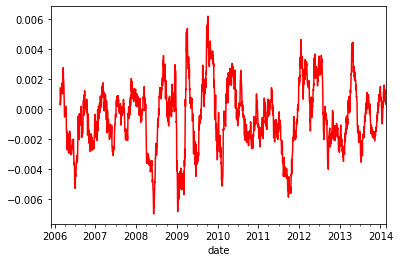

30 day Momentum based strategy
t-stat:  0.8539587263710019
Sharpe Ratio: 0.06385760777617429


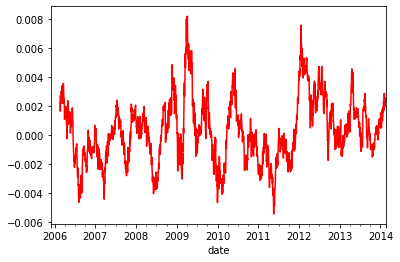

40 day Momentum based strategy
t-stat:  0.39591849310064675
Sharpe Ratio: 0.029606123882819996


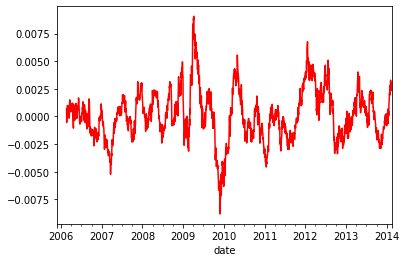

In [71]:
# Calculating figures and plotting portfolio
for i in maxlaglist:
    print(str(i) + ' day Momentum based strategy')
    # Calculating T Stat and Sharpe Ratio
    tstat = highminuslow[i].describe()['mean']/(highminuslow[i].describe()['std'] / np.sqrt(highminuslow[i].describe()['count']))
    print('t-stat: ', tstat)
    sharpe = highminuslow[i].describe()['mean']/highminuslow[i].describe()['std'] * np.sqrt(12)
    print('Sharpe Ratio:', sharpe)
    # Plotting Portfolio Performance
    highminuslow[i].rolling(60).mean().plot(color='r')
    plt.show()

# 2) Volatility - Energy Futures

### Volatility

- <u>__Objective__</u> <br>
To test volatility trading strategies on a portfolio of futures contracts of 4 commodities: crude oil,gasoline, natural gas, heating oil. We test volatility for three time periods: weekly volatility, monthly volatility and the relative volatility.
<br>

- <u>__Method__</u> <br>
We create quintiles of the return volatility for the three time periods (assuming that we're trading everyday) and test 2 strategies:
1. _Strategy 1_: Buy when volatility is low, sell when volatility is high.<br>
We buy futures contracts which are in quintile 1 and and sell contracts which are in quintile 5.
2. _Strategy 2_: Buy when volatility is high, sell when volatility is low.<br>
We buy futures contracts which are in quintile 5 and and sell contracts which are in quintile 1.


- <u>__Results__</u> <br>
Our results indicate that buying contracts when relative volatility is high, and selling when relative volatility is low returns the best Sharpe ratio of 0.105. Trying the opposite of this strategy i.e buying when volatility is low results in a negative sharpe ratio for all three time periods.

In [72]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [73]:
# loading crude, gas, natural gas, heatoil datasets
crude = pd.read_csv("Crude_Oil.txt",sep="\t")
gas = pd.read_csv("Gasoline.txt",sep="\t")
natgas = pd.read_csv("Natural_Gas.txt",sep="\t")
heatoil = pd.read_csv("Heating_Oil.txt",sep="\t")

In [74]:
# coverting to datetime columns
commodities = [crude,gas,natgas,heatoil]
for i in commodities:
    i.Date = pd.to_datetime(i.Date,dayfirst=True)

In [75]:
# merging dataframes on the common time period between the 4 commodities
df_merged= reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='inner'), commodities)

# showing only first row and last row of dataframe
# dataset ranges from 2005-10-03 --- 2014-02-18
df_merged.iloc[[0, -1]]

,Date,RCLC1,RCLC2,RCLC3,RCLC4,RCLC5,RCLC6,RCLC12,LLCC1,LLCC2,LLCC3,LLCC4,LLCC5,LLCC6,LLCC12,RBC1,RBC2,RBC3,RBC4,RBC5,RBC6,RBC7,RBC8,RBC9,RBC10,RBC11,RBC12,NGHenry,NNGC1,NNGC2,NNGC3,NNGC4,NNGC5,NNGC6,NNGC7,NNGC8,NNGC9,NNGC10,NNGC11,NNGC12,HOTC1,HOTC2,HOTC3,HOTC4,HOTC5,HOTC6,HOTC7,HOTC8,HOTC9,HOTC10,HOTC11,HOTC12
0,2005-10-03,65.47,65.29,65.69,65.97,66.16,66.24,65.77,62.80,63.52,64.13,64.50,64.72,64.82,64.45,1.8888,1.8653,1.8543,1.9408,1.9408,1.9328,1.9198,1.8983,1.8703,1.7653,1.7253,1.6953,14.84,14.017,14.557,14.892,14.617,14.127,10.977,10.442,10.442,10.472,10.502,10.477,10.504,2.0809,2.1098,2.1273,2.1248,2.0898,2.0223,1.9633,1.9223,1.9208,1.9273,1.9408,1.9578
2186,2014-02-18,102.43,102.10,101.21,100.30,99.40,98.45,93.11,110.46,110.11,109.71,109.27,108.77,108.15,105.10,2.8323,3.0007,2.9909,2.9608,2.9247,2.8832,2.8354,2.6819,2.6351,2.6028,2.5851,2.5821,5.74,5.551,4.753,4.662,4.675,4.703,4.688,4.661,4.673,4.708,4.821,4.918,4.857,3.1017,3.0452,3.0256,3.0163,3.0096,3.0033,2.9980,2.9918,2.9858,2.9793,2.9713,2.9566


In [76]:
# Reshaping data to index by contract and date
cols = list(df_merged.columns)[1:][:-1]
df = pd.melt(df_merged, id_vars=['Date'], value_vars=cols)

# Indicator for not Beginning of Month. 
df['BOM_not'] = (df.Date.shift(1).dt.month == df.Date.dt.month).astype(int)
df.columns = ['date', 'contract', 'price', 'BOM_not']
df.set_index(['contract', 'date'], inplace = True)
df

price  BOM_not
contract date                        
RCLC1    2005-10-03  65.4700        0
         2005-10-04  63.9000        1
         2005-10-05  62.7900        1
         2005-10-06  61.3600        1
         2005-10-07  61.8400        1
...                      ...      ...
HOTC11   2014-02-12   2.9304        1
         2014-02-13   2.9288        1
         2014-02-14   2.9438        1
         2014-02-17   2.9438        1
         2014-02-18   2.9713        1

[109350 rows x 2 columns]

In [77]:
# Calculating Return
df['lag_price'] = df['price'].groupby('contract').shift()
df['RET'] = (df['price']/df['lag_price'] - 1)*df['BOM_not']
df.drop(columns = ['price', 'lag_price', 'BOM_not'], inplace = True)
df

RET
contract date                
RCLC1    2005-10-03       NaN
         2005-10-04 -0.023980
         2005-10-05 -0.017371
         2005-10-06 -0.022774
         2005-10-07  0.007823
...                       ...
HOTC11   2014-02-12 -0.000512
         2014-02-13 -0.000546
         2014-02-14  0.005122
         2014-02-17  0.000000
         2014-02-18  0.009342

[109350 rows x 1 columns]

In [78]:
# Excess Return
df['XRET'] = df['RET'] -rf['RF']
df.fillna(value = 0, inplace = True)

In [79]:
# calculating standard deviation of weekly XRETurn
df['STD_WEEKLY'] = df.rolling(5)['XRET'].std()

# calculating standard deviation of monthly XRETurn
df['STD_MONTHLY'] = df.rolling(21)['XRET'].std()

# relative standard deviation
df['STD_RELATIVE'] = df['STD_WEEKLY']/df['STD_MONTHLY']

# weekly volatility of XRETurns
df['WEEKLY_XRET_VOL'] = df['STD_WEEKLY'].groupby('contract').shift()

# monthly volatility of XRETurns
df['MONTHLY_XRET_VOL'] = df['STD_MONTHLY'].groupby('contract').shift()

# lagging the relative volatility
df['RELATIVE_VOL_LAG'] = df['STD_RELATIVE'].groupby('contract').shift()

df.dropna(inplace = True)

In [80]:
#create dataframe to store contracts
rev = pd.DataFrame(data=cols,columns=["contract"])

In [81]:
# defining quintiles
numbins = 5
def quintiles(inser):
    outser = pd.qcut(inser, q=5, labels=range(1,6))
    return outser

In [82]:
periods = ['WEEKLY_XRET_VOL','MONTHLY_XRET_VOL','RELATIVE_VOL_LAG']
graph_titles = ['Weekly Return Volatility', 'Monthly Return Volatility', 'Relative Return Volatility']

In [83]:
# Making quintiles
ports = {}
stats = {}
for i in periods:
    df['QUANTILE_' + str(i)] = df[i].groupby('date').apply(quintiles)
    # Calculating Portfolios
    ports[i] = df.groupby(['QUANTILE_' + str(i),'date'])['XRET'].mean()
    # Calculating Stats for each quantile
    stats[i] = ports[i].groupby(['QUANTILE_'  + str(i)]).describe()
    stats[i]['sharpe'] = stats[i]['mean'] / stats[i]['std'] * np.sqrt(12)

In [84]:
stats[periods[0]]

,count,mean,std,min,25%,50%,75%,max,sharpe
QUANTILE_WEEKLY_XRET_VOL,,,,,,,,,
1,2186.0,-0.000067,0.015061,-0.076998,-0.007820,0.000000e+00,0.007932,0.071068,-0.015520
2,2186.0,0.000248,0.015533,-0.080290,-0.007868,0.000000e+00,0.008447,0.092258,0.055379
3,2186.0,0.000296,0.016865,-0.079922,-0.008183,0.000000e+00,0.008907,0.105444,0.060834
4,2186.0,0.000421,0.017386,-0.090776,-0.008437,0.000000e+00,0.009437,0.116919,0.083974
5,2186.0,0.000367,0.021391,-0.093416,-0.011506,-3.475000e-07,0.011269,0.124930,0.059376


In [85]:
stats[periods[1]]

,count,mean,std,min,25%,50%,75%,max,sharpe
QUANTILE_MONTHLY_XRET_VOL,,,,,,,,,
1,2186.0,-0.000111,0.014137,-0.065442,-0.008193,0.0,0.007357,0.080843,-0.027103
2,2186.0,0.000223,0.015575,-0.079253,-0.007858,0.0,0.008910,0.076760,0.049618
3,2186.0,0.000354,0.016838,-0.081390,-0.007697,0.0,0.008729,0.100387,0.072781
4,2186.0,0.000350,0.017411,-0.091716,-0.008278,0.0,0.008973,0.115990,0.069600
5,2186.0,0.000451,0.021733,-0.100571,-0.011657,0.0,0.011247,0.134775,0.071940


In [86]:
stats[periods[2]]

,count,mean,std,min,25%,50%,75%,max,sharpe
QUANTILE_RELATIVE_VOL_LAG,,,,,,,,,
1,2186.0,0.000083,0.017102,-0.092087,-0.008869,0.000000e+00,0.009311,0.088817,0.016856
2,2186.0,0.000398,0.016586,-0.093957,-0.008089,0.000000e+00,0.008598,0.094351,0.083047
3,2186.0,0.000308,0.017078,-0.081854,-0.008213,0.000000e+00,0.008774,0.106104,0.062453
4,2186.0,0.000338,0.016952,-0.083864,-0.008362,0.000000e+00,0.009273,0.114201,0.068987
5,2186.0,0.000139,0.018764,-0.086659,-0.010007,-6.950000e-08,0.009771,0.094079,0.025621


### Trading Rule
Buy when volatility is low, sell when volatility is high

In [87]:
# Summarizing Each Strategy
lowminushigh = {}
for i in periods:
    lowminushigh[i] = ports[i].loc[1] - ports[i].loc[5]
    print(str(i))
    print(lowminushigh[i].describe(), '\n')

WEEKLY_XRET_VOL
count    2186.000000
mean       -0.000434
std         0.019486
min        -0.150656
25%        -0.009549
50%         0.000000
75%         0.009063
max         0.076368
Name: XRET, dtype: float64 

MONTHLY_XRET_VOL
count    2186.000000
mean       -0.000562
std         0.019104
min        -0.160501
25%        -0.009126
50%         0.000000
75%         0.008377
max         0.076540
Name: XRET, dtype: float64 

RELATIVE_VOL_LAG
count    2186.000000
mean       -0.000056
std         0.018267
min        -0.119805
25%        -0.008304
50%         0.000000
75%         0.008668
max         0.071440
Name: XRET, dtype: float64 



WEEKLY_XRET_VOL day volatility based strategy
t-stat:  -1.041684437505675
Sharpe Ratio: -0.07717945725506112


/Users/kwlwman2/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


MONTHLY_XRET_VOL day volatility based strategy
t-stat:  -1.3753002818002396
Sharpe Ratio: -0.10189739376949924


/Users/kwlwman2/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


RELATIVE_VOL_LAG day volatility based strategy
t-stat:  -0.1422220778043961
Sharpe Ratio: -0.010537378095917425


/Users/kwlwman2/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


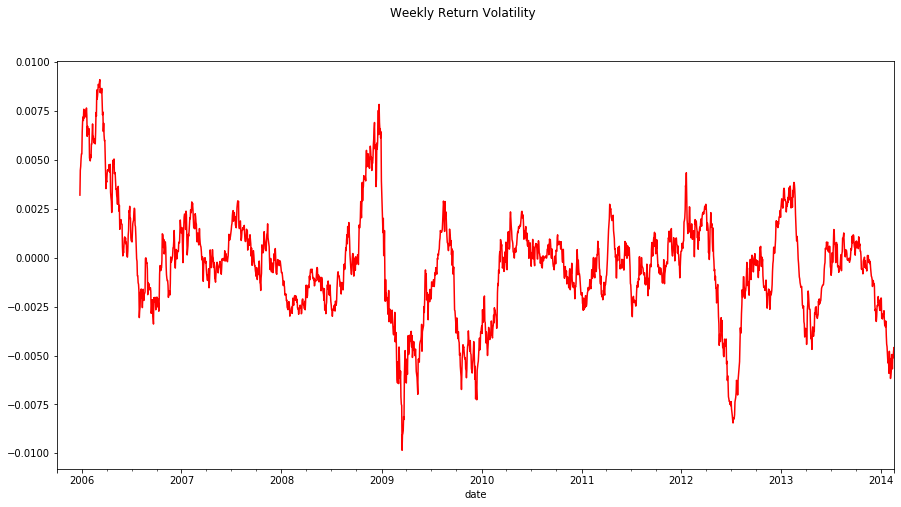

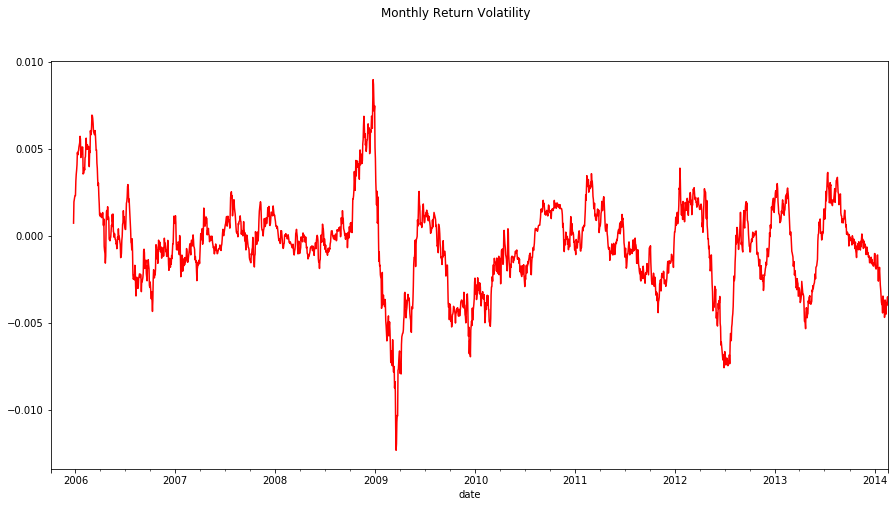

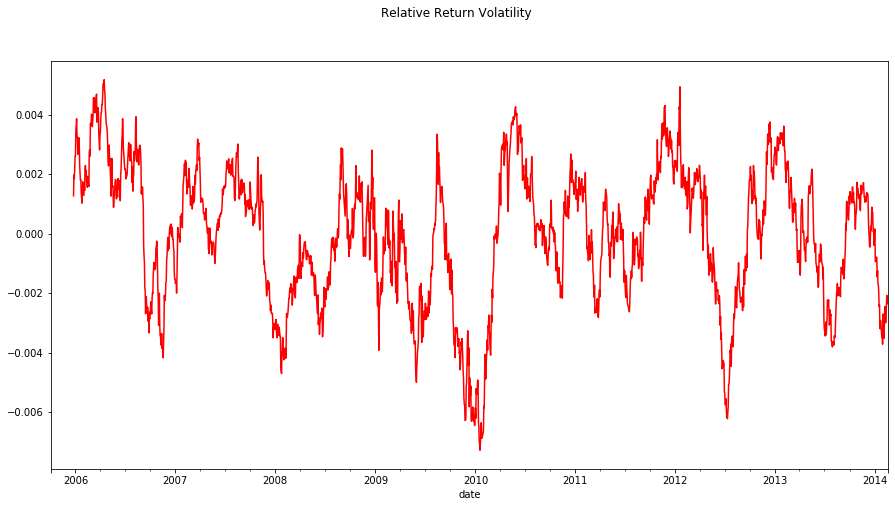

In [88]:
# Calculating figures and plotting portfolio
for idx,i in enumerate(periods):
    print(str(i) + ' day volatility based strategy')
    # Calculating T Stat and Sharpe Ratio
    tstat = lowminushigh[i].describe()['mean']/(lowminushigh[i].describe()['std'] / np.sqrt(lowminushigh[i].describe()['count']))
    print('t-stat: ', tstat)
    sharpe = lowminushigh[i].describe()['mean']/lowminushigh[i].describe()['std'] * np.sqrt(12)
    print('Sharpe Ratio:', sharpe)
    # Plotting Portfolio Performance
    fig = plt.figure(figsize = (15, 7.5))
    lowminushigh[i].rolling(60).mean().plot(color='r')
    fig.suptitle(str(graph_titles[idx]))
    fig.show()
    fig.savefig('volatility_' + str(i) + '.png')

### Trading Rule
Buy when volatility is high, sell when volatility is low

In [89]:
# Summarizing Each Strategy
highminuslow = {}
for i in periods:
    highminuslow[i] = ports[i].loc[numbins] - ports[i].loc[1]
    print(str(i))
    print(highminuslow[i].describe(), '\n')

WEEKLY_XRET_VOL
count    2186.000000
mean        0.000434
std         0.019486
min        -0.076368
25%        -0.009063
50%         0.000000
75%         0.009549
max         0.150656
Name: XRET, dtype: float64 

MONTHLY_XRET_VOL
count    2186.000000
mean        0.000562
std         0.019104
min        -0.076540
25%        -0.008377
50%         0.000000
75%         0.009126
max         0.160501
Name: XRET, dtype: float64 

RELATIVE_VOL_LAG
count    2186.000000
mean        0.000056
std         0.018267
min        -0.071440
25%        -0.008668
50%         0.000000
75%         0.008304
max         0.119805
Name: XRET, dtype: float64 



WEEKLY_XRET_VOL day volatility based strategy
t-stat:  1.041684437505675
Sharpe Ratio: 0.07717945725506112


/Users/kwlwman2/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


MONTHLY_XRET_VOL day volatility based strategy
t-stat:  1.3753002818002396
Sharpe Ratio: 0.10189739376949924


/Users/kwlwman2/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


RELATIVE_VOL_LAG day volatility based strategy
t-stat:  0.1422220778043961
Sharpe Ratio: 0.010537378095917425


/Users/kwlwman2/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


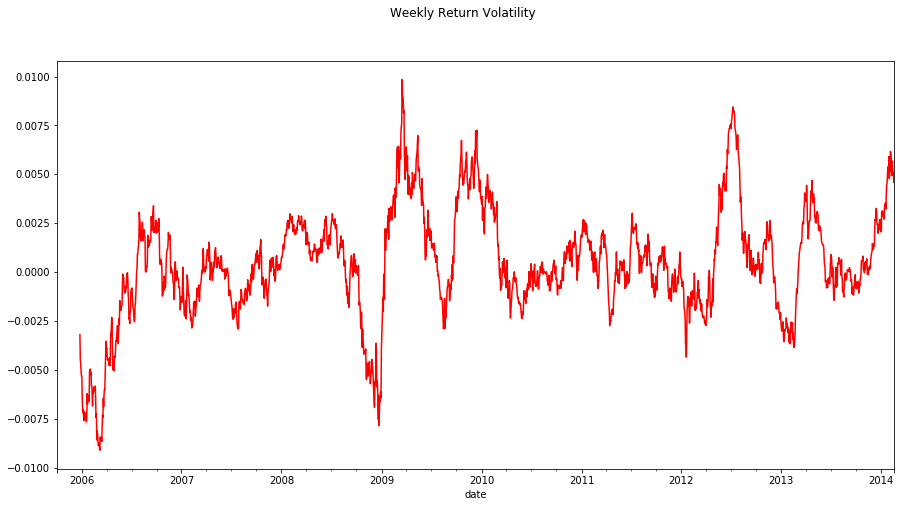

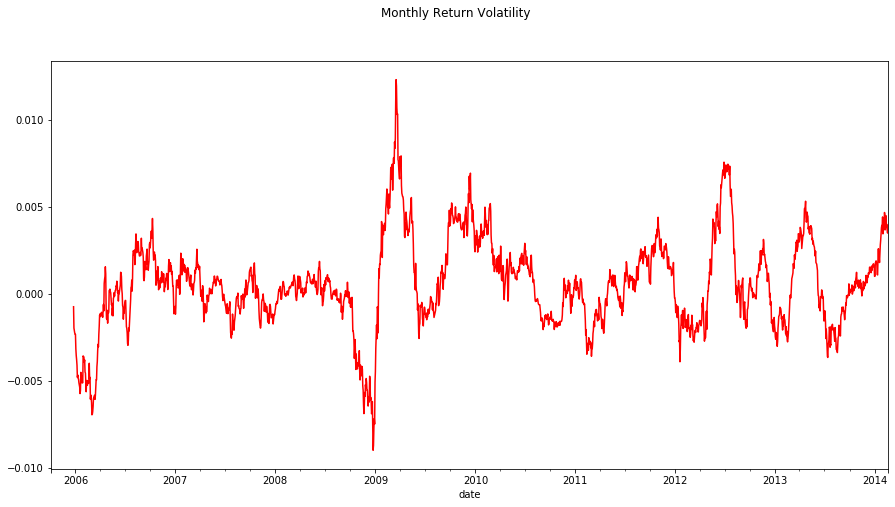

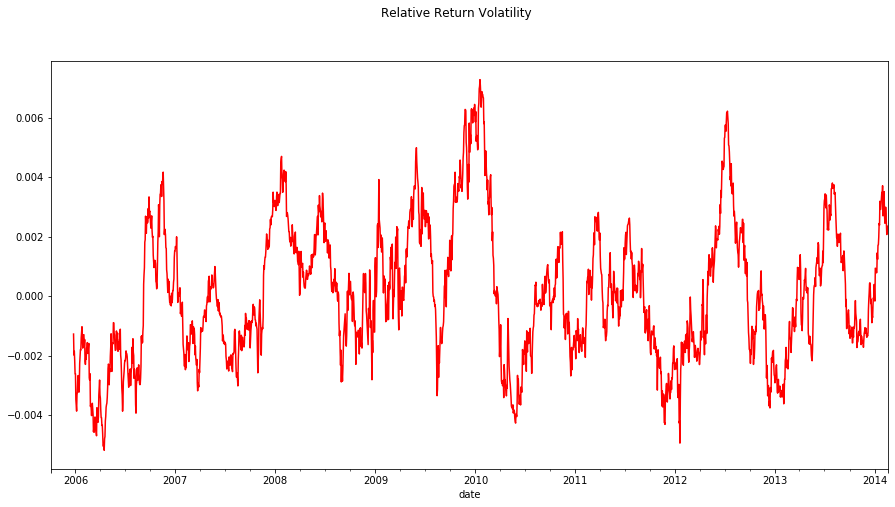

In [90]:
# Calculating figures and plotting portfolio
for idx,i in enumerate(periods):
    print(str(i) + ' day volatility based strategy')
    # Calculating T Stat and Sharpe Ratio
    tstat = highminuslow[i].describe()['mean']/(highminuslow[i].describe()['std'] / np.sqrt(highminuslow[i].describe()['count']))
    print('t-stat: ', tstat)
    sharpe = highminuslow[i].describe()['mean']/highminuslow[i].describe()['std'] * np.sqrt(12)
    print('Sharpe Ratio:', sharpe)
    # Plotting Portfolio Performance
    fig = plt.figure(figsize = (15, 7.5))
    highminuslow[i].rolling(60).mean().plot(color='r')
    fig.suptitle(str(graph_titles[idx]))
    fig.show()
    fig.savefig('volatility_' + str(i) + '.png')

In [91]:
end = dt.datetime.now()
print(end-start)

0:36:39.094093
